# MAP inference

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/e/ed/Bayes_icon.svg" width="300px" height="300px" />

> In classes 6 and 7 we focused our attention to inference methods the find conditional probability queries. In this class, we turn our attention to MAP queries, which are also very useful in several applications (recall the motivating example of the first class).
>
> As a reminder, a MAP query aims to find the most likely assignment to all of the non-evidence variables. Similarly, a marginal MAP query aims to find the most likely assignment to a subset of the variables.

> **Objetives:**
> - To reformulate the Variable Elimination method for MAP inference.
> - To reformulate the Belief Propagation algorithm for MAP inference.

> **References:**
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Ch. 13.
> - Mastering Probabilistic Graphical Models Using Python, By Ankur Ankan and Abinash Panda. Ch. 3.
> - Probabilistic Graphical Models Specialization, offered through Coursera. Prof. Daphne Koller.


<p style="text-align:right;"> Imagen recuperada de: https://upload.wikimedia.org/wikipedia/commons/e/ed/Bayes_icon.svg.</p>

___

# 1. Variable Elimination

We begin studying the most fundamental inference algorithm: variable elimination.

## 1.1. Max-product variable elimination

Let's introduce this problem though a simple example.

**Example.** Consider the following BN

In [1]:
from IPython.display import Image

In [2]:
Image("figures/simpleExample.png")

Or goal is to compute:

$$\begin{align}
\max_{a,b} P(A=a, B=b)  & = \max_{a,b} P(A=a)P(B=b | A=a) \\
                        & = \max_{a} \max_{b} P(A=a)P(B=b | A=a).
\end{align}$$

From this last form, we would want to choose $a$ so that

$$\max_{b} P(A=a)P(B=b | A=a) = P(A=a) \max_{b}P(B=b | A=a)$$

is maximum. Hence,

- a **necessary condition** of the joint MAP assignment $a,b$ is that $b$ is selected to maximize $P(B=b | A=a)$. 

- This is not sufficient, however, since we must choose $a$ appropriately.

For instance, consider the following CPDs

In [3]:
Image("figures/simpleExample2.png")

Let's denote $\max_{b}P(B=b | A=a) = \phi_1(a)$. Then 

- $\phi_1(a^0)=0.9$
- $\phi_1(a^1)=0.55$

Finally,

$$\max_{a} P(a) \phi_1(a) = \max_{a} \phi_2(a)=0.36$$

| $A$ | $\phi_2$           |
| --- | ------------------ |
|$a^0$|$0.9\times0.4=0.36$ |
|$a^1$|$0.55\times0.6=0.33$|

### Important comments:

- One can note that the operation $\max_{b}P(B=b | A=a) = \phi_1(a)$ corresponds to a *max-marginalization* of the $P(B|A)$ factor.

- Just like in conditional probability queries, this step marginalizes out the variable $B$, not by summing, but by maximizing it.

- One key point is: Assume we are given two factors $\phi_1,\phi_2$ and that $X\notin \mathrm{scope}[\phi_1]$, then

  $$\max_{X} \phi_1 \phi_2 = \phi_1 \max_{X} \phi_2.$$
 
  This is, we can push in the maximization operations (just as we push in the summation operations) over factors that don't involve the variable being maximized. Similarly,
  
  $$\max_{X} (\phi_1 + \phi_2) = \phi_1 + \max_{X} \phi_2.$$

The final comment directly leads to the **max-product and max-sum variable elimination algorithms** which is completely dual to the **sum-prod variable elimination algorithm** that we studied in class 6.

### Max-product variable elimination algorithm

We will describe the steps for eliminating some variable $Z$ from $\bar{\Phi}$: *Eliminate Var-$Z$ from $\bar{\Phi}$*.

1. Determine the set of factors that involve $Z$:

   $$\bar{\Phi}' = \left\{\phi_i \in \bar{\Phi} : Z  \in \mathrm{scope}[\phi_i]\right\}$$

2. Compute:

   $$\psi = \prod_{\phi_i \in \bar{\Phi}'} \phi_i$$
   
3. Compute:

   $$\tau = \max_Z \psi$$
   
   Store the value $z^\ast$ that maximizes $\psi$.
   
4. Overwrite:
   
   $$\bar{\Phi} := \left(\bar{\Phi}\setminus \bar{\Phi}'\right) \cup \{\tau\}$$

Thus, the complete algorithm can be described as:

1. The first step is to reduce all factors in $\bar{\Phi}$ acording to the given evidence, if any.

2. For each non-query variable $Z$:
   - Eliminate Var-$Z$ from $\bar{\Phi}$.

3. Multiply all the remaining factors.

## 1.2. Max-sum variable elimination algorithm

Often, the values of some factors are so small that, when multipled together, they may produce values that are less than the processor/memory resolution: **numerical underflow**.

One effective way of dealing with this situation is to consider the $\log$ of the factors.

We have that:

$$P_{\bar{\Phi}} (\bar{X}) \propto \prod_{k} \phi_{k} (\bar{X}_k)$$

and we want,

$$\arg \max_{X} \prod_{k} \phi_{k} (\bar{X}_k) = \arg \max_{X} \log\left(\prod_{k} \phi_{k} (\bar{X}_k)\right) = \arg \max_{X} \sum_{k} \log\left(\phi_{k} (\bar{X}_k)\right),$$

since the $\log$ is an increasing function.

Thus, converting factors with the logarithm allows us to interchange products by sum, obtaining some **practical robustness against numerical underflow**.

The algorithm is completely analogous:

### Max-sum variable elimination algorithm

We will describe the steps for eliminating some variable $Z$ from $\bar{\Phi}$: *Eliminate Var-$Z$ from $\bar{\Phi}$*.

0. Take the $log$ of all the factors:

   $$\theta_k(\bar{X}_k) = \log{\phi_k}(\bar{X}_k).$$
   
   $$\bar{\Theta} = \{\theta_{1}(\bar{X}_1), \dots, \theta_{m}(\bar{X}_m)\}.$$

1. Determine the set of factors that involve $Z$:

   $$\bar{\Theta}' = \left\{\theta_i \in \bar{\Theta} : Z  \in \mathrm{scope}[\theta_i]\right\}$$

2. Compute:

   $$\psi = \sum_{\theta_i \in \bar{\Theta}'} \phi_i$$
   
3. Compute:

   $$\tau = \max_Z \psi$$
   
   Store the value $z^\ast$ that maximizes $\psi$.
   
4. Overwrite:
   
   $$\bar{\Theta} := \left(\bar{\Theta}\setminus \bar{\Theta}'\right) \cup \{\tau\}$$

How is this done in `pgmpy`?

In [4]:
Image("figures/restaurant.png")

In [5]:
# Import pgmpy.models.BayesianModel
from pgmpy.models import BayesianModel
# Import pgmpy.factors.discrete.TabularCPD
from pgmpy.factors.discrete import TabularCPD

In [6]:
# Define model skeleton
restaurant = BayesianModel([('L', 'C'), ('Q', 'C'), ('L', 'N'), ('C', 'N')])

In [7]:
# Define CPDs
P_L = TabularCPD(variable='L',
                 variable_card=2,
                 values=[[0.4], [0.6]])
P_Q = TabularCPD(variable='Q',
                 variable_card=3,
                 values=[[0.2], [0.5], [0.3]])
P_CgivenLQ = TabularCPD(variable='C',
                        evidence=['L', 'Q'],
                        variable_card=2,
                        evidence_card=[2, 3],
                        values=[[0.95, 0.4, 0.4, 0.9, 0.4, 0.2],
                                [0.05, 0.6, 0.6, 0.1, 0.6, 0.8]])
P_NgivenLC = TabularCPD(variable='N',
                        evidence=['L', 'C'],
                        variable_card=2,
                        evidence_card=[2, 2],
                        values=[[0.4, 0.9, 0.2, 0.4],
                                [0.6, 0.1, 0.8, 0.6]])

In [8]:
# Attach CPDs to the model
restaurant.add_cpds(P_L, P_Q, P_CgivenLQ, P_NgivenLC)

In [9]:
# Check if the model is correctly defined
restaurant.check_model()

True

In [10]:
# Import pgmpy.inference.VariableElimination
from pgmpy.inference import VariableElimination

In [11]:
# Create VariableElimination inference object
ve_inference = VariableElimination(restaurant)

In [12]:
# Map query
print(ve_inference.map_query(variables=['N'],
                             evidence={'L': 1, 'Q': 2}))

Eliminating: C: 100%|██████████| 1/1 [00:00<00:00, 677.70it/s]

{'N': 1}


In [13]:
# Max marginal
print(ve_inference.max_marginal(variables=['N'],
                                evidence={'L': 1, 'Q': 2}))

Eliminating: C: 100%|██████████| 1/1 [00:00<00:00, 443.19it/s]

0.6


# 2. Max-sum Belief Propagation

We start by a simple example

### Max-sum elimination in chains

Consider the following chain

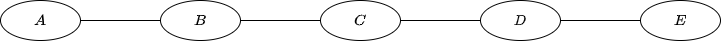

In [14]:
Image("figures/chain.png")

We want:

$$\begin{align}
\max_{D} \max_{C} \max_{B} \max_{A} \theta(A,B,C,D,E) & = \max_{D} \max_{C} \max_{B} \max_{A} \theta(A,B,C,D,E) \\
                                                      & = \max_{D} \max_{C} \max_{B} \max_{A} \left(\theta_1(A,B) + \theta_2(B,C) + \theta_3(C,D) + \theta_4(D,E)\right) \\
                                                      & = \max_{D} \max_{C} \max_{B} \left(\theta_2(B,C) + \theta_3(C,D) + \theta_4(D,E) + \max_{A}\theta_1(A,B)\right)
\end{align}$$

___
**1. Sum of factors**

$$\phi_1(A, B)$$

|   A   |   B   | $\phi_1$ |
| ----- | ----- | -------- |
| $a^0$ | $b^0$ | 5        |
| $a^0$ | $b^1$ | 8        |
| $a^1$ | $b^0$ | 1        |
| $a^1$ | $b^1$ | 0        |
| $a^2$ | $b^0$ | 3        |
| $a^2$ | $b^1$ | 9        |

$$\phi_2(B, C)$$

|   B   |   C   | $\phi_1$ |
| ----- | ----- | -------- |
| $b^0$ | $c^0$ | 5        |
| $b^0$ | $c^1$ | 7        |
| $b^1$ | $c^0$ | 1        |
| $b^1$ | $c^1$ | 2        |

$$\phi_3(A, B, C) = \phi_1(A, B) + \phi_2(B, C)$$

|   A   |   B   |   C   | $\phi_3$     |
| ----- | ----- | ----- | ------------ |
| $a^0$ | $b^0$ | $c^0$ | $5 + 5 = 10$ |
| $a^0$ | $b^0$ | $c^1$ | $5 + 7 = 12$ |
| $a^0$ | $b^1$ | $c^0$ | $8 + 1 = 9$  |
| $a^0$ | $b^1$ | $c^1$ | $8 + 2 = 10$ |
| $a^1$ | $b^0$ | $c^0$ | $1 + 5 = 6$  |
| $a^1$ | $b^0$ | $c^1$ | $1 + 7 = 8$  |
| $a^1$ | $b^1$ | $c^0$ | $0 + 1 = 1$  |
| $a^1$ | $b^1$ | $c^1$ | $0 + 2 = 2$  |
| $a^2$ | $b^0$ | $c^0$ | $3 + 5 = 8$  |
| $a^2$ | $b^0$ | $c^1$ | $3 + 7 = 10$ |
| $a^2$ | $b^1$ | $c^0$ | $9 + 1 = 10$ |
| $a^2$ | $b^1$ | $c^1$ | $9 + 2 = 11$ |

**2. Max reduction**

$$\phi_3(A, B, C)$$

|   A   |   B   |   C   | $\phi_3$     |
| ----- | ----- | ----- | ------------ |
| $a^0$ | $b^0$ | $c^0$ | $5 + 5 = 10$ |
| $a^0$ | $b^0$ | $c^1$ | $5 + 7 = 12$ |
| $a^0$ | $b^1$ | $c^0$ | $8 + 1 = 9$  |
| $a^0$ | $b^1$ | $c^1$ | $8 + 2 = 10$ |
| $a^1$ | $b^0$ | $c^0$ | $1 + 5 = 6$  |
| $a^1$ | $b^0$ | $c^1$ | $1 + 7 = 8$  |
| $a^1$ | $b^1$ | $c^0$ | $0 + 1 = 1$  |
| $a^1$ | $b^1$ | $c^1$ | $0 + 2 = 2$  |
| $a^2$ | $b^0$ | $c^0$ | $3 + 5 = 8$  |
| $a^2$ | $b^0$ | $c^1$ | $3 + 7 = 10$ |
| $a^2$ | $b^1$ | $c^0$ | $9 + 1 = 10$ |
| $a^2$ | $b^1$ | $c^1$ | $9 + 2 = 11$ |


$$\phi_4(A, B) = \max_{C}\phi_3(A, B, C)$$

|   A   |   B   | $\phi_3$     |
| ----- | ----- | ------------ |
| $a^0$ | $b^0$ | $5 + 7 = 12$ |
| $a^0$ | $b^1$ | $8 + 2 = 10$ |
| $a^1$ | $b^0$ | $1 + 7 = 8$  |
| $a^1$ | $b^1$ | $0 + 2 = 2$  |
| $a^2$ | $b^0$ | $3 + 7 = 10$ |
| $a^2$ | $b^1$ | $9 + 2 = 11$ |

___

$$\begin{align}
\max_{D} \max_{C} \max_{B} \max_{A} \theta(A,B,C,D,E) & = \max_{D} \max_{C} \max_{B} \max_{A} \theta(A,B,C,D,E) \\
                                                      & = \max_{D} \max_{C} \max_{B} \max_{A} \left(\theta_1(A,B) + \theta_2(B,C) + \theta_3(C,D) + \theta_4(D,E)\right) \\
                                                      & = \max_{D} \max_{C} \max_{B} \left(\theta_2(B,C) + \theta_3(C,D) + \theta_4(D,E) + \max_{A}\theta_1(A,B)\right) \\
                                                      & = \max_{D} \max_{C} \max_{B} \left(\theta_2(B,C) + \theta_3(C,D) + \theta_4(D,E) + \tau_1(B)\right) \\
                                                      & = \max_{D} \max_{C} \left(\theta_3(C,D) + \theta_4(D,E) + \max_{B} (\theta_2(B,C)+ \tau_1(B))\right) \\
                                                      & = \max_{D} \left(\theta_4(D,E) + \max_{C} (\theta_3(C,D) + \tau_2(C))\right) \\
                                                      & = \max_{D} \left(\theta_4(D,E) + \tau_3(D)\right) \\
                                                      & = \tau_4(E)
\end{align}$$

### Max-sum in clique trees

Consider the clique tree of the above chain:

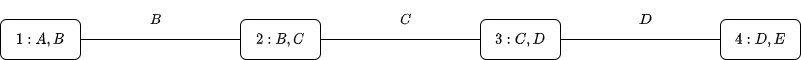

In [15]:
Image("figures/clusterGraphChain.png")

The message passing has the same idea in this context:

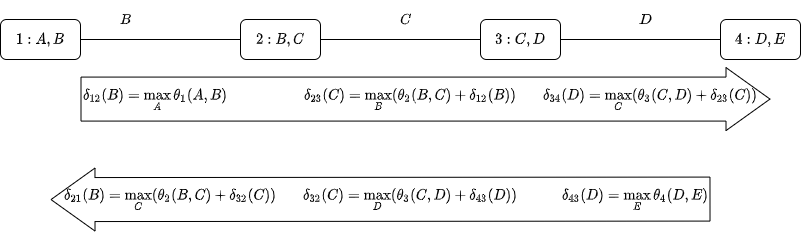

In [16]:
Image("figures/clusterGraphChain2.png")

Then, the forward-backward algorithm we defined for conditional probability queries in clique trees is exactly the same for MAP queries. 

We only have to change products by sums/products, and reduction by max-reductions.

How is this done in `pgmpy`?

In [17]:
# Import pgmpy.inference.BeliefPropagation
from pgmpy.inference import BeliefPropagation

In [18]:
# Create BeliefPropagation inference object
bp_inference = BeliefPropagation(restaurant)

In [19]:
# MAP query
print(bp_inference.map_query(variables=['N'],
                             evidence={'L': 1, 'Q': 2}))

Eliminating: C: 100%|██████████| 1/1 [00:00<00:00, 317.53it/s]

{'N': 1}


# 3. Application - Classification

Let's use the example in the first class

In [20]:
# Library imports (sklearn.datasets.load_iris, pandas y numpy)
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

In [21]:
# Data loading (integer parts, for simplicity)
iris = load_iris()
X = iris['data'][:, :2].astype(int)
y = iris['target']
df = pd.DataFrame(X, columns=['sepal_length', 'sepal_width'])
df['target'] = y
df

,sepal_length,sepal_width,target
0,5,3,0
1,4,3,0
2,4,3,0
3,4,3,0
4,5,3,0
...,...,...,...
145,6,3,2
146,6,2,2
147,6,3,2
148,6,3,2


| Type of flower | label  |
| -------------- | ------ |
| Setosa         | 0      |
| Versicolor     | 1      |
| Virginica      | 2      |

In [22]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

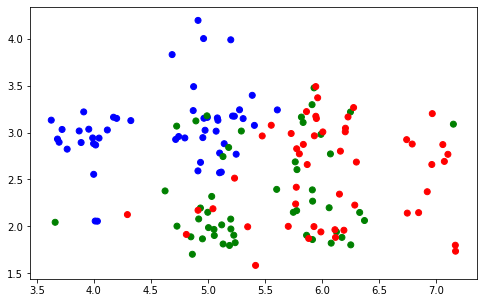

In [23]:
# Scatter plot (largo vs. ancho), color regarding type of flower. Add a bit of noise
l = df['sepal_length'] + np.random.normal(0, 0.2, (len(df), ))
w = df['sepal_width'] + np.random.normal(0, 0.2, (len(df), ))
plt.figure(figsize=(8, 5))
plt.scatter(l, w, c=['bgr'[c] for c in df['target']])
plt.show()

In [24]:
# Import sklearn.model_selection.train_test_split
from sklearn.model_selection import train_test_split

In [25]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

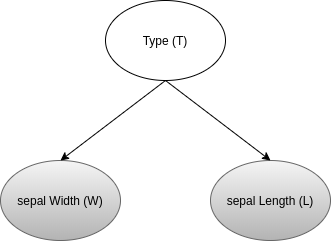

In [26]:
Image('figures/iris.png')

In [27]:
# Flower model
flower_model = BayesianModel([('T', 'W'), ('T', 'L')])

In [28]:
# Generate train frame
train = pd.DataFrame(columns=['L', 'W', 'T'], index=range(len(y_train)))
train.loc[:, ['L', 'W']] = X_train
train.loc[:, 'T'] = y_train
train.head()

,L,W,T
0,5,3,0
1,6,3,1
2,5,3,1
3,6,2,2
4,6,3,1


In [29]:
# Train model
flower_model.fit(train)

In [30]:
# Generate test frame
test = pd.DataFrame(columns=['L', 'W', 'T'], index=range(len(y_test)))
test.loc[:, ['L', 'W']] = X_test
test.loc[:, 'T'] = y_test
test.head()

,L,W,T
0,5,3,0
1,6,3,1
2,6,2,2
3,5,3,0
4,6,3,2


In [31]:
# Predict (MAP Assignment)
y_pred = flower_model.predict(test.loc[:, ['L', 'W']])

100%|██████████| 7/7 [00:00<00:00, 569.02it/s]


In [32]:
# Accuracy
(y_pred.values.T == y_test).sum() / len(y_test)

0.7

# Announcements

## 1. Homework, due on monday.

## 2. Quizz the next class.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>